In [18]:
# Install required libraries

%pip install numpy scikit-learn matplotlib networkx torch torchvision torchaudio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 4.4 MB/s eta 0:00:000:00:010:00:01:01

[notice] A new release of pip available: 22.2.2 -> 22.3
[notice] To update, run: python3.10 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [1]:
import numpy as np
import sklearn
import torch
from matplotlib import pyplot as plt
import networkx as nx

print(f"numpy {np.__version__}")
print(f"scikit-learn {sklearn.__version__}")
print(f"pytorch {torch.__version__}")

numpy 1.23.4
scikit-learn 1.1.2
pytorch 1.12.1


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


## Tensor operations in pytorch

In [65]:
ones = torch.ones((2, 3))
ones

tensor([[1., 1., 1.],
        [1., 1., 1.]])

In [67]:
zeros = torch.zeros((4,))
zeros

tensor([0., 0., 0., 0.])

In [74]:
np_array = np.eye(4)
torch_tensor = torch.from_numpy(np_array)
np_array, torch_tensor

(array([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]]),
 tensor([[1., 0., 0., 0.],
         [0., 1., 0., 0.],
         [0., 0., 1., 0.],
         [0., 0., 0., 1.]], dtype=torch.float64))

In [72]:
np_array[1, :] = [1, 2, 3, 4]
np_array, torch_tensor

(array([[1., 0., 0., 0.],
        [1., 2., 3., 4.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]]),
 tensor([[1., 0., 0., 0.],
         [1., 2., 3., 4.],
         [0., 0., 1., 0.],
         [0., 0., 0., 1.]], dtype=torch.float64))

In [75]:
torch_tensor.float()

tensor([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]])

In [78]:
a = torch.ones((3, 3))
e = torch.eye(3)
a @ e

tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]])

In [7]:
# See https://pytorch.org/tutorials/beginner/basics/autogradqs_tutorial.html

x = torch.ones(5)  # input tensor
y = torch.zeros(3)  # expected output
w = torch.randn(5, 3, requires_grad=True)
b = torch.randn(3)
b.requires_grad_(True)
z = torch.matmul(x, w)+b
loss = torch.nn.functional.binary_cross_entropy_with_logits(z, y)
loss.backward()
w.grad, b.grad

(tensor([[0.1436, 0.0795, 0.0020],
         [0.1436, 0.0795, 0.0020],
         [0.1436, 0.0795, 0.0020],
         [0.1436, 0.0795, 0.0020],
         [0.1436, 0.0795, 0.0020]]),
 tensor([0.1436, 0.0795, 0.0020]))

## Example #1: Multilayer perceptron

See also https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html

In [4]:
# Download MNIST dataset
from torchvision import datasets
from torchvision.transforms import ToTensor

mnist_train = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

mnist_test = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

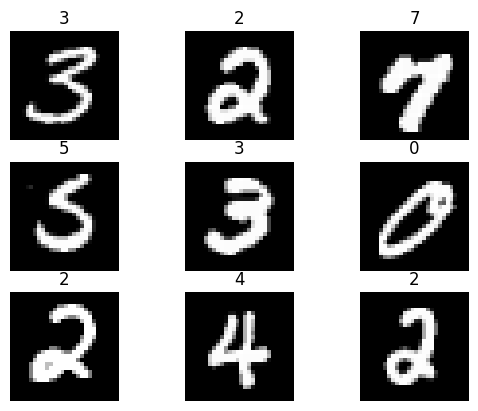

In [14]:
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(mnist_train), size=(1,)).item()
    img, label = mnist_train[sample_idx]
    plt.subplot(rows, cols, i)
    plt.title(str(label))
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [31]:
class MultilayerPerceptron(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = torch.nn.Flatten()
        self.linear_sigmoid_stack = torch.nn.Sequential(
            torch.nn.Linear(28*28, 16),
            torch.nn.ReLU(),
            torch.nn.Linear(16, 16),
            torch.nn.ReLU(),
            torch.nn.Linear(16, 10),
        )
    
    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_sigmoid_stack(x)
        return logits
    
model = MultilayerPerceptron().to(device)
model

MultilayerPerceptron(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_sigmoid_stack): Sequential(
    (0): Linear(in_features=784, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=10, bias=True)
  )
)

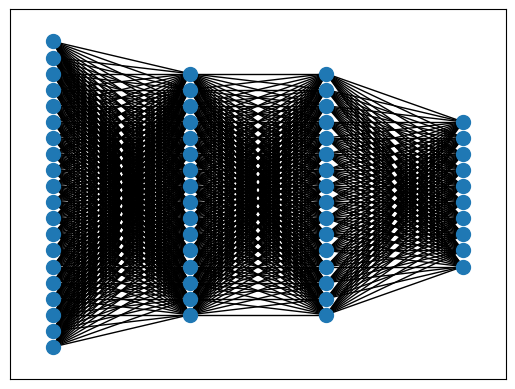

In [14]:
from itertools import product

network = nx.Graph()
for i, module in enumerate(model.linear_sigmoid_stack.children()):
    if isinstance(module, torch.nn.Linear):
        nodes = [(i, j) for j in range(module.in_features)][:20]  # NOTICE: 20 nodes per layer drawing limit
        network.add_nodes_from([(node, {"subset": i}) for node in nodes])
        if i != 0:
            network.add_edges_from(product(prev, nodes))
        prev = nodes
out_nodes = [(i + 1, j) for j in range(module.out_features)]
network.add_nodes_from([(node, {"subset": i + 1}) for node in out_nodes])
network.add_edges_from(product(prev, out_nodes))
pos = nx.multipartite_layout(network)
nx.draw_networkx(network, pos=pos, node_size=100, width=1, with_labels=False)
plt.show()

In [15]:
from torch.utils.data import DataLoader

batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(mnist_train, batch_size=batch_size)
test_dataloader = DataLoader(mnist_test, batch_size=batch_size)

In [28]:
X, y = next(train_dataloader.__iter__())
print("X:", X.shape)
print("y:", y.shape)

X: torch.Size([64, 1, 28, 28])
y: torch.Size([64])


In [30]:
model(X).shape

/var/folders/m4/pvgjytq93s9cykb2_2p4dpkhhkvdy7/T/ipykernel_66439/1400596616.py:17: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.softmax(logits)


torch.Size([64, 10])

In [32]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)  # stochastic gradient descent

In [33]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [34]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [35]:
epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.308414  [    0/60000]
loss: 2.297382  [ 6400/60000]
loss: 2.339338  [12800/60000]
loss: 2.277516  [19200/60000]
loss: 2.310667  [25600/60000]
loss: 2.315088  [32000/60000]
loss: 2.312616  [38400/60000]
loss: 2.320033  [44800/60000]
loss: 2.297530  [51200/60000]
loss: 2.276890  [57600/60000]
Test Error: 
 Accuracy: 16.9%, Avg loss: 2.287871 

Epoch 2
-------------------------------
loss: 2.284658  [    0/60000]
loss: 2.284308  [ 6400/60000]
loss: 2.307233  [12800/60000]
loss: 2.254299  [19200/60000]
loss: 2.277620  [25600/60000]
loss: 2.287798  [32000/60000]
loss: 2.262683  [38400/60000]
loss: 2.299075  [44800/60000]
loss: 2.266033  [51200/60000]
loss: 2.232738  [57600/60000]
Test Error: 
 Accuracy: 21.5%, Avg loss: 2.249376 

Epoch 3
-------------------------------
loss: 2.251813  [    0/60000]
loss: 2.258695  [ 6400/60000]
loss: 2.262769  [12800/60000]
loss: 2.219239  [19200/60000]
loss: 2.230555  [25600/60000]
loss: 2.243865  [32000/600

In [40]:
torch.save(model.state_dict(), "model")  # Save our model state

In [41]:
model.load_state_dict(torch.load("model"))  # Loac

OrderedDict([('linear_sigmoid_stack.0.weight',
              tensor([[ 0.0241,  0.0016,  0.0090,  ..., -0.0271,  0.0143, -0.0340],
                      [-0.0077, -0.0060, -0.0104,  ...,  0.0262, -0.0142, -0.0281],
                      [-0.0310, -0.0253, -0.0211,  ...,  0.0139,  0.0150, -0.0240],
                      ...,
                      [ 0.0309, -0.0146,  0.0248,  ...,  0.0256, -0.0157, -0.0205],
                      [ 0.0104,  0.0007,  0.0279,  ..., -0.0270,  0.0306, -0.0180],
                      [-0.0013,  0.0277,  0.0167,  ..., -0.0022,  0.0220,  0.0120]])),
             ('linear_sigmoid_stack.0.bias',
              tensor([ 0.0345, -0.0071,  0.0505,  0.0715,  0.0742,  0.0854, -0.0044,  0.0181,
                       0.0339,  0.0142,  0.0028,  0.0158, -0.0294,  0.1519,  0.0962,  0.0558])),
             ('linear_sigmoid_stack.2.weight',
              tensor([[-0.2506, -0.0076,  0.3107, -0.1155, -0.2043,  0.2988, -0.3758,  0.1435,
                        0.1757,  0.2427, 